# Exercise 18: Supernovae with GPR

First let's fit our supernova synthetic data from last time using GPR.

- The key ingrediente in getting a good GPR fit is the choice of the kernel and its parameters.
- Check out what's available in the `kernels` submodule of [sklearn.gaussian_process](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.gaussian_process)
- *Hint*. Radial-basis function kernel (aka squared-exponential kernel) is a standard choice in the GPR world.
- Plot the expectation value of the fit as well as the resulting 1-$\sigma$ and 2-$\sigma$ contours.
- Interpret the results.

*Note*. We have time constraints, so feel free to tweak the hyperparameters manually while in class. But, of course, a publication-quality result will require a cross-validation analysis. (Do this at home before the exam?)

We now have a suite of *data-driven predictive models* for our supernova dataset. That is: we can faithfully predict how a future redshift/distance measurement will look like given the current sample.

This is already great and these kind of tools are immensely useful in a variety of contexts (also involving a lot of money: suppose you want to predict how much a give financial asset will perform on tomorrow's stock market... You  might not really care about expressing the underlying financial model in simple terms, as long as your investments are profitable).

For the case of supernovae, however, we have do have physical theory which is $\Lambda$CDM.

- First, refresh your cosmology and write down the predicted relationship between the distance module $\mu$ and the redshift $z$. *Hint* I always forget these things, my to-go reference is [Hogg (2010)](https://arxiv.org/abs/astro-ph/9905116). I got:

$$\mu = 5 \log \left( \frac{c/H_0} {10 {\rm pc}}(1+z)\int_0^z \frac{dz'}{\sqrt{\Omega_m (1+z^3)+\Omega_\Lambda}} \right) $$


- Assuming a flat Universe,  we have a parametric non-linear model for $\mu(z)$ that depends on two parameters, the Hubble constant $H_0$ and the matter content of the Universe $\Omega_m$
- It's a very non-linear model. Fir it to the data (however you want to do it).
- What are the measured value of $H_0$ and $\Omega_m$. Are they correlated?
- How would a model without dark energy (i.e. $\Omega_m=1$) perform? Do these data contain evidence of dark energy?

The European Space Agency is considering new cosmology-related space mission. They ask you to figure out what science you can do with 10 times more measurement compared to what you have right now. That is: you want to clone your data. We've seen this earlier in the class, but now we can do much better.
- Assume a uniform distribution in redshifts between 0 and z.
- Using both the GPR fit and your latest $\Lambda$CDM fit, generate a set of $\mu$ measurements that respects the statistical properties of the data you were given. 

---


# GPR fit

In [1]:
import numpy as np
import pylab as plt

from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import ConstantKernel, RBF 

from astroML.datasets import generate_mu_z

In [8]:
z, mu, dmu = np.asarray(generate_mu_z(100, random_state=1234))

z_sk = z[:,None]

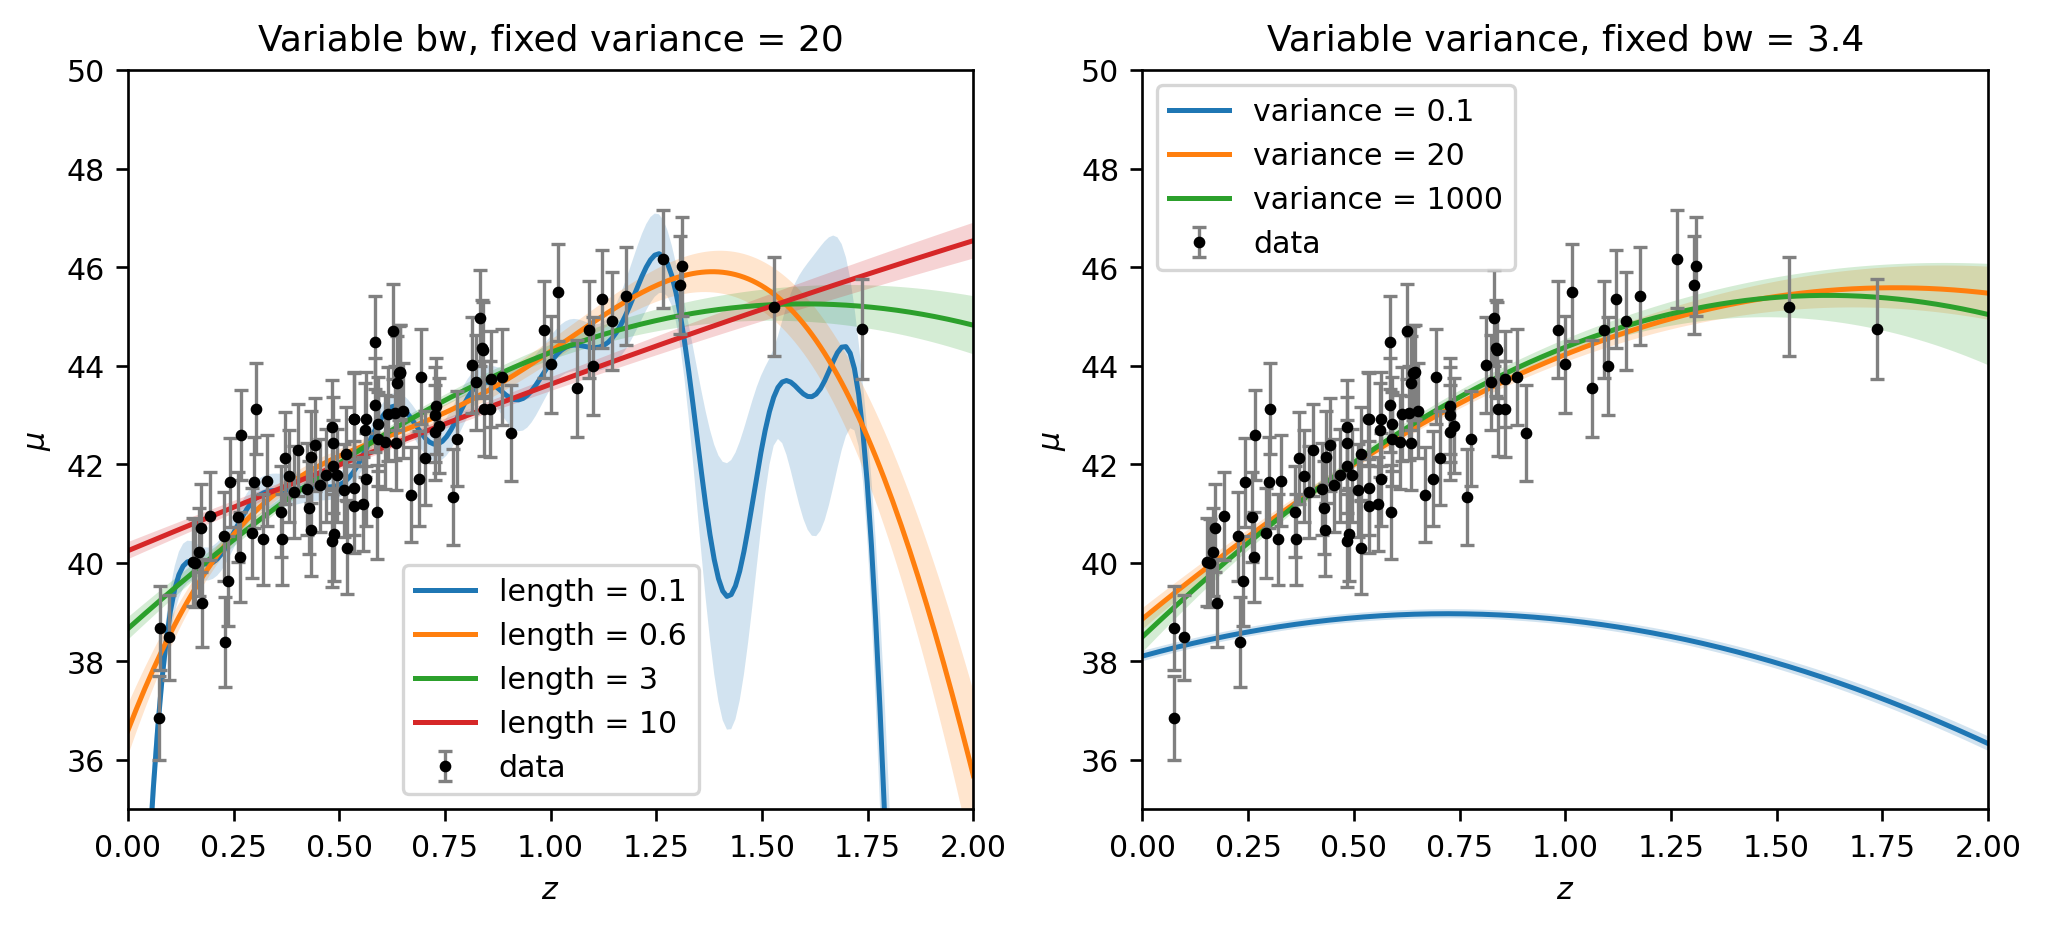

In [130]:
# See the effect of changing variance and bandwidth for GPR kernel

#-------  Plt params  ----------------
%config InlineBackend.figure_format='retina'
plt.rc('figure', figsize=(10, 4), dpi=120)
plt.rcParams.update({'font.size': 9})
#--------------------------------------------




z_grid = np.linspace(0,2,200)

fig = plt.figure()

ax = fig.add_subplot(121)

var = 20
l_kern_list = [0.1,0.6,3,10]

for l in l_kern_list:
    kernel = ConstantKernel(var, 'fixed') * RBF(l, 'fixed')
    gpr = GaussianProcessRegressor(kernel = kernel, alpha = dmu**2)
    gpr.fit(z_sk, mu)
    mu_gpr, mu_sigma = gpr.predict(z_grid[:,None], return_std=True)
    
    ax.plot(z_grid, mu_gpr, label= f'length = {l}')
    ax.fill_between(z_grid, mu_gpr - mu_sigma, mu_gpr + mu_sigma, alpha = 0.2)

ax.errorbar(z, mu, dmu, fmt='.k', ecolor='gray', lw=1,label='data', capsize = 2, markersize=5)
ax.set_xlabel(r"$z$")
ax.set_ylabel("$\mu$")
ax.set_xlim(0,2)
ax.set_ylim(35,50)
ax.set_title(f'Variable bw, fixed variance = {var}')
ax.legend()

ax = fig.add_subplot(122)

bw = 3.4
c_kern_list = [0.1,20,1000]

for c in c_kern_list:
    kernel = ConstantKernel(c, 'fixed') * RBF(bw, 'fixed')
    gpr = GaussianProcessRegressor(kernel = kernel, alpha = dmu**2)
    gpr.fit(z_sk, mu)
    mu_gpr, mu_sigma = gpr.predict(z_grid[:,None], return_std=True)
    
    ax.plot(z_grid, mu_gpr, label= f'variance = {c}')
    ax.fill_between(z_grid, mu_gpr - mu_sigma, mu_gpr + mu_sigma, alpha = 0.2)

ax.errorbar(z, mu, dmu, fmt='.k', ecolor='gray', lw=1,label='data', capsize = 2, markersize=5)
ax.set_xlabel(r"$z$")
ax.set_ylabel("$\mu$")
ax.set_xlim(0,2)
ax.set_ylim(35,50)
ax.set_title(f'Variable variance, fixed bw = {bw}')
ax.legend();

From the plot on the right, we see that with a reasonable bandwidth, we should worry about having a variance which is high enough. Anyway after a certain point (maybe around 20 here), the change in variance does not have a great influenxe on the best distribution estimate, but it seems crucial to increase uncertainty in poorly - populated areas. **So the parameter search should explore a quite big interval (maybe different orders of magnitude)**

From plot on the left we see that bandwidth is crucial to control the smoothness of the distribution estimate. Anyway we see that with a reasonable choice of variance, passing from 0.1 to 10 we go from overfitting to underfitting quite fast. **The parameter search can stay within thinner bounds.**

In [117]:
# Cross validation using GridSearch, takes a while

# c_kern_list = np.logspace(-2,2,25)
# l_kern_list = np.logspace(-2,2,25)

c_kern_list = np.logspace(-1,4,25)
l_kern_list = np.linspace(0.1,10,25)

k_range = []

for c in c_kern_list:
    for l in l_kern_list:
        
        kernel = ConstantKernel(c, constant_value_bounds='fixed') * RBF(l, length_scale_bounds='fixed')
        k_range.append(kernel)
        
alpha = np.mean(dmu**2)  #  use this as homoscedastic error because gridsearch goes 
                                                    #  crazy if I put the whole array

grid = GridSearchCV(GaussianProcessRegressor(alpha=0.9), {'kernel': k_range}, cv = 10)
grid.fit(z_sk, mu);

In [118]:
print(grid.best_params_)

{'kernel': 11.5**2 * RBF(length_scale=0.925)}


In [137]:
print(grid.cv_results_)

{'mean_fit_time': array([0.00844176, 0.00160172, 0.00177917, 0.00155506, 0.00285053,
       0.00149398, 0.00168631, 0.00247219, 0.00223906, 0.0014065 ,
       0.0033766 , 0.00195398, 0.00179782, 0.00150561, 0.00229185,
       0.00150714, 0.0015655 , 0.00692937, 0.00162125, 0.00165594,
       0.002163  , 0.00164807, 0.00295448, 0.00300233, 0.00254838,
       0.01468835, 0.02080615, 0.0023118 , 0.00521638, 0.00219474,
       0.00382352, 0.00741804, 0.02165105, 0.00829761, 0.00321112,
       0.00160499, 0.00204508, 0.00155151, 0.00215843, 0.00332031,
       0.00284598, 0.00415714, 0.00388253, 0.00225739, 0.00162797,
       0.00168116, 0.00158081, 0.0019567 , 0.00161266, 0.00150812,
       0.00197623, 0.00185952, 0.00251288, 0.00158703, 0.00242119,
       0.0049999 , 0.0080982 , 0.00619221, 0.00168777, 0.00154674,
       0.00208046, 0.00157413, 0.00159025, 0.00280266, 0.00305877,
       0.00162663, 0.00214086, 0.00185516, 0.0025332 , 0.00191913,
       0.00214696, 0.00223353, 0.00183794, 0

Best fit with: 
- constant = 11.5
- length = 0.9

We use these values as starting point for the optimizer in the GaussianProcess algorithm

In [120]:
kernel = ConstantKernel(11.5, (1e-2, 1e4)) * RBF(1 , (0.1, 10))
gpr = GaussianProcessRegressor(kernel=kernel, random_state=404, alpha = dmu**2)
gpr.fit(z_sk, mu)

GaussianProcessRegressor(alpha=array([0.84387183, 0.91812087, 0.89001003, 0.94522717, 0.94422381,
       0.86154897, 0.86230499, 0.94838417, 0.9933467 , 0.9646779 ,
       0.87701523, 0.89976228, 0.92772472, 0.93248803, 0.87910942,
       0.90886653, 0.90007965, 0.74796941, 0.94290888, 0.96641079,
       0.87820976, 0.91709206, 0.80479835, 0.87887073, 0.98216481,
       0.92265029, 0.8835475 , 0.94586178, 0.86985...
       0.93684146, 0.91281498, 0.89527413, 0.81855684, 0.85259287,
       0.97119502, 0.88669278, 0.90504074, 0.72518962, 0.86689404,
       0.88987903, 0.91659546, 0.97685316, 0.91867826, 0.93138181,
       0.83270862, 0.93814442, 0.95430226, 0.9199094 , 0.89010136,
       0.83350663, 0.90995601, 0.90388843, 0.98995206, 0.89661359,
       0.90000008, 0.90519576, 0.95184399, 0.79454928, 0.92548723]),
                         kernel=3.39**2 * RBF(length_scale=1),
                         random_state=404)

In [121]:
gpr.kernel_

30.7**2 * RBF(length_scale=3.9)

Cross-val search was not so bad, but probably not more accurate than a manual graphical manual exploration (surely the dataset here is simple enough, so we it's a possibility)

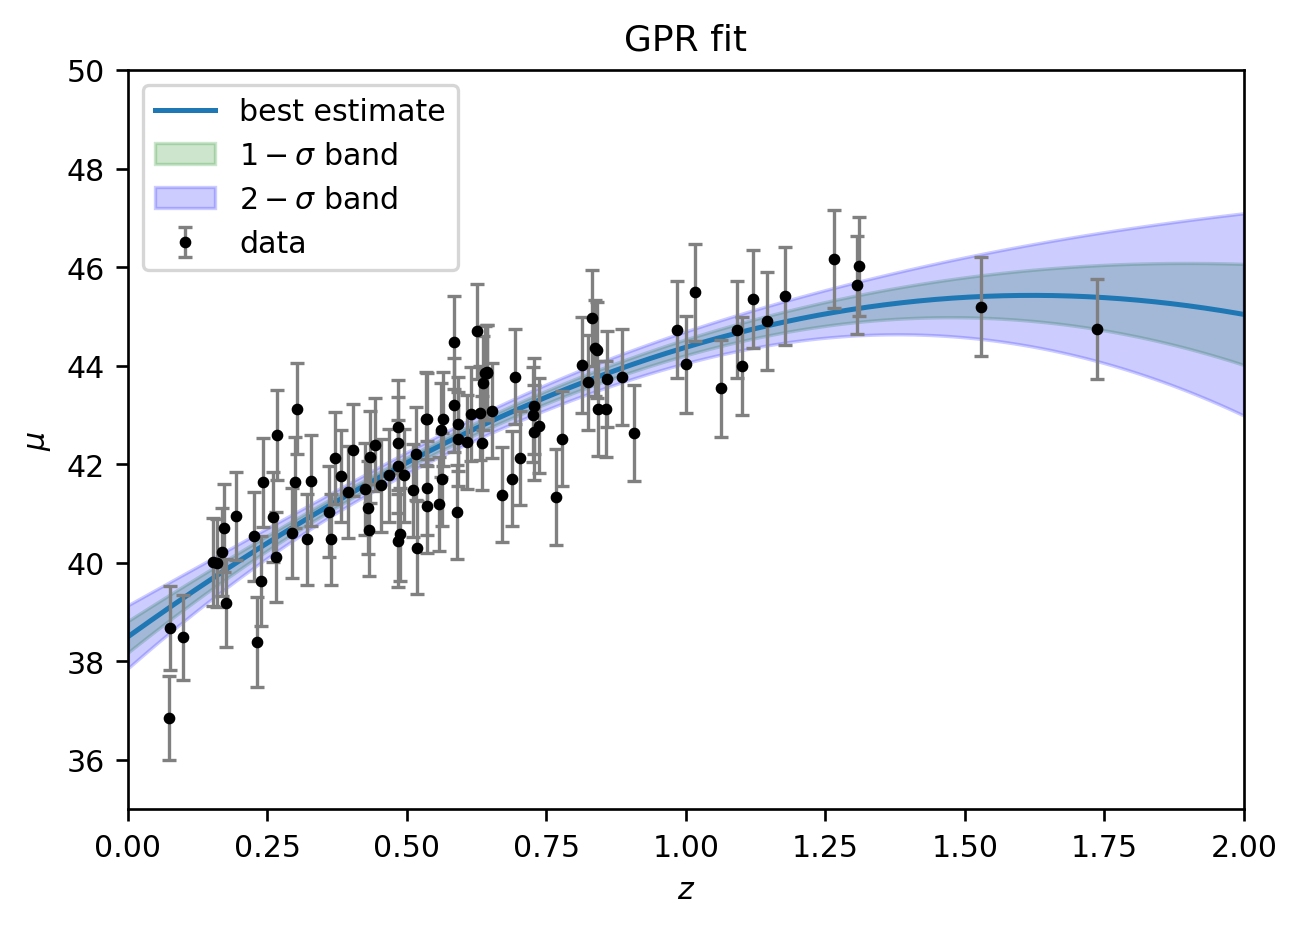

In [136]:
gpr.fit(z_sk, mu)
mu_gpr, mu_sigma = gpr.predict(z_grid[:,None], return_std=True)

fig,ax = plt.subplots(figsize=(6, 4))

ax.plot(z_grid, mu_gpr ,label= 'best estimate')
ax.fill_between(z_grid, mu_gpr - mu_sigma, mu_gpr + mu_sigma, color='g', alpha = 0.2, label=r'$1-\sigma$ band')
ax.fill_between(z_grid, mu_gpr - 2*mu_sigma, mu_gpr + 2*mu_sigma, color='b', alpha = 0.2, label=r'$2-\sigma$ band')

ax.errorbar(z, mu, dmu, fmt='.k', ecolor='gray', lw=1,label='data', capsize = 2, markersize=5)
ax.set_xlabel(r"$z$")
ax.set_ylabel("$\mu$")
ax.set_xlim(0,2)
ax.set_ylim(35,50)
ax.set_title(f'GPR fit')
ax.legend();

# Analytic model fit
We will use Nested Sempling to do parameter estimation of the model.